# _ Linear regression model to predict future stock price_

##### Dataset source used: www.quandl.com
1. BAC : (Stock symbol for Bank of America) Target Stock for prediction
2. SPY ( ETF S&P Index): (SPY.csv)
3. VIX (CBOE Volatility Index): (VIX.csv)(The CBOE Volatility Index® (VIX®) is a key measure of market expectations of near-term volatility conveyed by S&P 500 stock index option prices.)
4. CBOE S&P 500 Index Option Volume and Put-Call Ratios: (SPX_PC.csv)


In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error

# visualization
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

#make it so that we only show first 4 decimals for floats
np.set_printoptions(precision=4,suppress=True)

import timeit

In [2]:
# read data into a DataFrame
def get_stockdata(symbol):
    df = None
    if symbol == 'SPY':
        df = pd.read_csv("./stockdata/{0}".format(symbol)+".csv",index_col=['Date'],usecols=['Date','Close','Volume'])  
        df.columns = ['close','vol']
        return df
    if symbol == 'VIX':
        df = pd.read_csv("./stockdata/{0}".format(symbol)+".csv",index_col=['Date'],usecols=['Date','VIX Close'])  
        df.columns = ['VIX_close']
        return df
    if symbol == 'SPX_PC':
        df = pd.read_csv("./stockdata/{0}".format(symbol)+".csv",index_col=['Date'],usecols=['Date','S&P PUT-CALL RATIO'])  
        df.columns = ['put_call_ratio']
        return df
    if symbol not in ['SPY','VIX']:
        df = pd.read_csv("./stockdata/{0}".format(symbol)+".csv",index_col=['date'],usecols=['date','adj_close','adj_volume'])
        df.columns = ['close','vol']
        return df

In [3]:
# Read csv data in dataframe
stock_data = get_stockdata('BAC') # Predict future price of this stock 'BAC'
# stock_data = stock_data.sort_index()
SPY_data = get_stockdata('SPY') # S&P 500 - gives direction of overall market
# SPY_data = SPY_data.sort_index()
VIX_data = get_stockdata('VIX') # Volatility index of S&P 500
# VIX_data = VIX_data.sort_index()
Put_Call_data = get_stockdata('SPX_PC') # put call ratio of S&P 500
# Put_Call_data = Put_Call_data.sort_index()

In [4]:
# Prediction of future stock price on n'th day
days_to_look_forward = 5

In [5]:
stock_data.index = stock_data.index.map(lambda x: pd.to_datetime(x,format="%Y-%m-%d"))
SPY_data.index = SPY_data.index.map(lambda x: pd.to_datetime(x,format="%Y-%m-%d"))
VIX_data.index = VIX_data.index.map(lambda x: pd.to_datetime(x,format="%Y-%m-%d"))
Put_Call_data.index = Put_Call_data.index.map(lambda x: pd.to_datetime(x,format="%Y-%m-%d"))

In [6]:
# Merge BAC, SPY, VIX and Put_call data
stock_data = stock_data.join(SPY_data, how="inner", rsuffix="_SPY")
stock_data = stock_data.join(VIX_data, how="inner")
stock_data = stock_data.join(Put_Call_data, how="left")

stock_data = stock_data.sort_index(ascending=True)

In [7]:
stock_data.tail()

,close,vol,close_SPY,vol_SPY,VIX_close,put_call_ratio
2016-11-10,18.76,303446906.0,216.92,172113313.0,14.74,1.33
2016-11-11,19.02,212372863.0,216.42,100552732.0,14.17,1.86
2016-11-14,20.08,319185424.0,216.59,94579982.0,14.48,1.24
2016-11-15,20.16,186692294.0,218.28,91652580.0,13.37,1.35
2016-11-16,19.75,126063792.0,217.87,65617697.0,13.72,1.18


In [8]:
# Target variable 'y' is the stock price after certain days = n days
stock_data["future_date"]=pd.datetime(1900,1,1) # Initialize
stock_data["future_date"][:-days_to_look_forward] = stock_data.index[days_to_look_forward:]

stock_data["future_price"]=-1 # Initialize
stock_data["future_price"][:-days_to_look_forward] = stock_data["close"][days_to_look_forward:]

#note: date of 1900-01-01 and future price of -1 signifies the lack of sufficient prod data

/home/sunil/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/sunil/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
print stock_data.dtypes
stock_data[-22:].head()

close                    float64
vol                      float64
close_SPY                float64
vol_SPY                  float64
VIX_close                float64
put_call_ratio           float64
future_date       datetime64[ns]
future_price             float64
dtype: object


,close,vol,close_SPY,vol_SPY,VIX_close,put_call_ratio,future_date,future_price
2016-10-18,16.26,69541795.0,213.71,76869656.0,15.28,1.48,2016-10-25,16.72
2016-10-19,16.47,96067710.0,214.28,66519224.0,14.41,1.57,2016-10-26,16.87
2016-10-20,16.56,87359023.0,213.88,73639830.0,13.75,1.46,2016-10-27,16.91
2016-10-21,16.67,72848885.0,213.98,89089092.0,13.34,1.96,2016-10-28,16.68
2016-10-24,16.77,65295884.0,214.89,60146592.0,13.02,2.22,2016-10-31,16.50


In [10]:
stock_data[-days_to_look_forward-1:].tail() #ix['2016-10-19':'2016-10-20']

,close,vol,close_SPY,vol_SPY,VIX_close,put_call_ratio,future_date,future_price
2016-11-10,18.76,303446906.0,216.92,172113313.0,14.74,1.33,1900-01-01,-1.0
2016-11-11,19.02,212372863.0,216.42,100552732.0,14.17,1.86,1900-01-01,-1.0
2016-11-14,20.08,319185424.0,216.59,94579982.0,14.48,1.24,1900-01-01,-1.0
2016-11-15,20.16,186692294.0,218.28,91652580.0,13.37,1.35,1900-01-01,-1.0
2016-11-16,19.75,126063792.0,217.87,65617697.0,13.72,1.18,1900-01-01,-1.0


In [11]:
# Features variables X
stock_data["daily_return"]=0.000000001
stock_data["daily_return"][1:]=np.log(stock_data["close"][1:]/stock_data["close"][:-1].values)  #- 1

/home/sunil/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [12]:
stock_data["daily_return"].tail()

2016-11-10    0.043023
2016-11-11    0.013764
2016-11-14    0.054233
2016-11-15    0.003976
2016-11-16   -0.020547
Name: daily_return, dtype: float64

In [13]:
# Calculate rolling stats of 'close' price using window size of n days
stock_data["rolling_mean"]=pd.rolling_mean(stock_data["close"],window=days_to_look_forward)
stock_data["rolling_sd"]=pd.rolling_std(stock_data["close"],window=days_to_look_forward)
stock_data["rolling_mean"].fillna(0,inplace=True)
stock_data["rolling_sd"].fillna(0,inplace=True)

/home/sunil/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()
  from ipykernel import kernelapp as app
/home/sunil/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).std()
  app.launch_new_instance()


In [14]:
stock_data.tail()

,close,vol,close_SPY,vol_SPY,VIX_close,put_call_ratio,future_date,future_price,daily_return,rolling_mean,rolling_sd
2016-11-10,18.76,303446906.0,216.92,172113313.0,14.74,1.33,1900-01-01,-1.0,0.043023,17.458,0.893348
2016-11-11,19.02,212372863.0,216.42,100552732.0,14.17,1.86,1900-01-01,-1.0,0.013764,17.952,0.947032
2016-11-14,20.08,319185424.0,216.59,94579982.0,14.48,1.24,1900-01-01,-1.0,0.054233,18.566,1.155803
2016-11-15,20.16,186692294.0,218.28,91652580.0,13.37,1.35,1900-01-01,-1.0,0.003976,19.198,0.926671
2016-11-16,19.75,126063792.0,217.87,65617697.0,13.72,1.18,1900-01-01,-1.0,-0.020547,19.554,0.632044


In [15]:
# One of the features used - "Bollinger Bands"
# A simple way to interpret in our case -- buy when price touches the lower Bollinger Band and exit when price 
#   touches the moving average in the center of the bands. 
def get_bollinger_bands(x):
    upper_band, lower_band = x["rolling_mean"] + 2*x["rolling_sd"], x["rolling_mean"] - 2*x["rolling_sd"]
    return upper_band, lower_band

In [16]:
stock_data["bollinger_band"]=stock_data[["rolling_mean","rolling_sd"]].apply(get_bollinger_bands,axis=1)
stock_data["upper_bollinger_band"]=stock_data["bollinger_band"].apply(lambda x: x[0])
stock_data["lower_bollinger_band"]=stock_data["bollinger_band"].apply(lambda x: x[1])
stock_data = stock_data.drop("bollinger_band", axis = 1)

In [17]:
# Backfill put_call_ratio (with first known value)
stock_data.fillna(method="bfill",inplace=True)

In [18]:
stock_data[-22:].head()

,close,vol,close_SPY,vol_SPY,VIX_close,put_call_ratio,future_date,future_price,daily_return,rolling_mean,rolling_sd,upper_bollinger_band,lower_bollinger_band
2016-10-18,16.26,69541795.0,213.71,76869656.0,15.28,1.48,2016-10-25,16.72,0.012999,16.034,0.153395,16.340790,15.727210
2016-10-19,16.47,96067710.0,214.28,66519224.0,14.41,1.57,2016-10-26,16.87,0.012832,16.122,0.247730,16.617459,15.626541
2016-10-20,16.56,87359023.0,213.88,73639830.0,13.75,1.46,2016-10-27,16.91,0.005450,16.268,0.247730,16.763459,15.772541
2016-10-21,16.67,72848885.0,213.98,89089092.0,13.34,1.96,2016-10-28,16.68,0.006621,16.402,0.247730,16.897459,15.906541
2016-10-24,16.77,65295884.0,214.89,60146592.0,13.02,2.22,2016-10-31,16.50,0.005981,16.546,0.195780,16.937561,16.154439


In [19]:
stock_data.head()

,close,vol,close_SPY,vol_SPY,VIX_close,put_call_ratio,future_date,future_price,daily_return,rolling_mean,rolling_sd,upper_bollinger_band,lower_bollinger_band
2004-01-02,29.862675,16897000.0,111.23,34487200.0,18.22,1.91,2004-01-09,29.583267,1.000000e-09,0.000000,0.000000,0.000000,0.000000
2004-01-05,29.949518,14535400.0,112.44,27160100.0,17.49,1.91,2004-01-12,29.639904,2.903859e-03,0.000000,0.000000,0.000000,0.000000
2004-01-06,29.900433,15083600.0,112.55,19282500.0,16.73,1.91,2004-01-13,29.564388,-1.640275e-03,0.000000,0.000000,0.000000,0.000000
2004-01-07,29.832469,13346200.0,112.93,28340200.0,15.50,1.91,2004-01-14,29.923088,-2.275601e-03,0.000000,0.000000,0.000000,0.000000
2004-01-08,29.847572,13774200.0,113.38,34295500.0,15.61,1.91,2004-01-15,29.707868,5.061369e-04,29.878534,0.047038,29.972611,29.784457


In [20]:
stock_data = stock_data[stock_data.columns.tolist()[0:6]+stock_data.columns.tolist()[8:]+stock_data.columns.tolist()[6:8]]
stock_data.columns.tolist()

['close',
 'vol',
 'close_SPY',
 'vol_SPY',
 'VIX_close',
 'put_call_ratio',
 'daily_return',
 'rolling_mean',
 'rolling_sd',
 'upper_bollinger_band',
 'lower_bollinger_band',
 'future_date',
 'future_price']

In [21]:
stock_data[-22:].head()

,close,vol,close_SPY,vol_SPY,VIX_close,put_call_ratio,daily_return,rolling_mean,rolling_sd,upper_bollinger_band,lower_bollinger_band,future_date,future_price
2016-10-18,16.26,69541795.0,213.71,76869656.0,15.28,1.48,0.012999,16.034,0.153395,16.340790,15.727210,2016-10-25,16.72
2016-10-19,16.47,96067710.0,214.28,66519224.0,14.41,1.57,0.012832,16.122,0.247730,16.617459,15.626541,2016-10-26,16.87
2016-10-20,16.56,87359023.0,213.88,73639830.0,13.75,1.46,0.005450,16.268,0.247730,16.763459,15.772541,2016-10-27,16.91
2016-10-21,16.67,72848885.0,213.98,89089092.0,13.34,1.96,0.006621,16.402,0.247730,16.897459,15.906541,2016-10-28,16.68
2016-10-24,16.77,65295884.0,214.89,60146592.0,13.02,2.22,0.005981,16.546,0.195780,16.937561,16.154439,2016-10-31,16.50


In [22]:
#features
features_for_scaling = stock_data.columns.tolist()[:-2]
print features_for_scaling

['close', 'vol', 'close_SPY', 'vol_SPY', 'VIX_close', 'put_call_ratio', 'daily_return', 'rolling_mean', 'rolling_sd', 'upper_bollinger_band', 'lower_bollinger_band']


In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() #create a scaler object
X = stock_data[features_for_scaling]
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled,columns=["scaled_"+i for i in features_for_scaling])

In [24]:
stock_data.ix[:23]
stock_data.head()
# X_scaled.head()

,close,vol,close_SPY,vol_SPY,VIX_close,put_call_ratio,daily_return,rolling_mean,rolling_sd,upper_bollinger_band,lower_bollinger_band,future_date,future_price
2004-01-02,29.862675,16897000.0,111.23,34487200.0,18.22,1.91,1.000000e-09,0.000000,0.000000,0.000000,0.000000,2004-01-09,29.583267
2004-01-05,29.949518,14535400.0,112.44,27160100.0,17.49,1.91,2.903859e-03,0.000000,0.000000,0.000000,0.000000,2004-01-12,29.639904
2004-01-06,29.900433,15083600.0,112.55,19282500.0,16.73,1.91,-1.640275e-03,0.000000,0.000000,0.000000,0.000000,2004-01-13,29.564388
2004-01-07,29.832469,13346200.0,112.93,28340200.0,15.50,1.91,-2.275601e-03,0.000000,0.000000,0.000000,0.000000,2004-01-14,29.923088
2004-01-08,29.847572,13774200.0,113.38,34295500.0,15.61,1.91,5.061369e-04,29.878534,0.047038,29.972611,29.784457,2004-01-15,29.707868


In [25]:
# Vertical merge the scaled data with original
stock_data = stock_data.reset_index()   #To retain the index , which corresponds to Date column
stock_data=pd.concat([X_scaled,stock_data],axis=1)

In [26]:
stock_data.index

RangeIndex(start=0, stop=3226, step=1)

In [27]:
# set index
stock_data = stock_data.set_index('index')

In [28]:
print stock_data.index.max(), stock_data.index.min()

2016-11-16 00:00:00 2004-01-02 00:00:00


In [29]:
# Create a deep copy of stock_data & strip data at both ends according to "days_to_look_forward"
master_stock_data = stock_data.copy()
columns_replaced_with_underscores= [np.str.replace(i," ","_") for i in master_stock_data.columns.tolist()]
master_stock_data = master_stock_data[columns_replaced_with_underscores]
master_stock_data = master_stock_data[days_to_look_forward - 1:-days_to_look_forward]

In [30]:
stock_data[16:].head()
master_stock_data.head()

,scaled_close,scaled_vol,scaled_close_SPY,scaled_vol_SPY,scaled_VIX_close,scaled_put_call_ratio,scaled_daily_return,scaled_rolling_mean,scaled_rolling_sd,scaled_upper_bollinger_band,...,vol_SPY,VIX_close,put_call_ratio,daily_return,rolling_mean,rolling_sd,upper_bollinger_band,lower_bollinger_band,future_date,future_price
index,,,,,,,,,,,,,,,,,,,,,
2004-01-08,0.641526,-0.807226,-0.843463,-0.752980,-0.390706,0.263057,0.019280,0.645855,-0.728656,0.590862,...,34295500.0,15.61,1.91,0.000506,29.878534,0.047038,29.972611,29.784457,2004-01-15,29.707868
2004-01-09,0.620060,-0.812149,-0.870865,-0.672058,-0.265755,0.263057,-0.266462,0.641321,-0.497970,0.601549,...,41431900.0,16.75,1.91,-0.008895,29.822652,0.141569,30.105791,29.539514,2004-01-16,29.836245
2004-01-12,0.624660,-0.831196,-0.848169,-0.794372,-0.258082,0.263057,0.062032,0.636297,-0.502024,0.596314,...,30645300.0,16.82,1.91,0.001913,29.760729,0.139908,30.040545,29.480913,2004-01-20,30.232702
2004-01-13,0.618526,-0.831997,-0.866159,-0.628947,-0.124362,0.263057,-0.073645,0.630845,-0.509860,0.590405,...,45233800.0,18.04,1.91,-0.002551,29.693520,0.136697,29.966914,29.420126,2004-01-21,30.904792
2004-01-14,0.647659,-0.814448,-0.839312,-0.843773,-0.265755,0.263057,0.370463,0.632315,-0.445260,0.596108,...,26288700.0,16.75,1.91,0.012060,29.711644,0.163169,30.037982,29.385306,2004-01-22,30.848155


In [31]:
# Split entire data in test/train data and production data
prod_data_window = 90

# Strip test_train data and prod data according to "days_to_look_forward"
prod_data = master_stock_data[-prod_data_window:]
test_train_data = master_stock_data[:-prod_data_window]

In [32]:
prod_data.shape
test_train_data.shape

(3127, 24)

In [33]:
# Stock features
X_features = [i for i in test_train_data.columns.tolist() if 'scaled' in i]
print X_features

['scaled_close', 'scaled_vol', 'scaled_close_SPY', 'scaled_vol_SPY', 'scaled_VIX_close', 'scaled_put_call_ratio', 'scaled_daily_return', 'scaled_rolling_mean', 'scaled_rolling_sd', 'scaled_upper_bollinger_band', 'scaled_lower_bollinger_band']


In [34]:
# Stock features & target
X = test_train_data[X_features]
y = test_train_data.future_price
prod_X = prod_data[X_features]

In [35]:
# Stock features & target
print "Using LinearRegression to predict"
from sklearn.linear_model import LinearRegression

import timeit
start_time_pgm = timeit.default_timer()

X_mult_train, X_mult_test, y_mult_train, y_mult_test = train_test_split(X, y, test_size=0.1, random_state=1)
print "training data size:",X_mult_train.shape
print "testing data size:",X_mult_test.shape
#train on training set
mult_linreg1 = LinearRegression()
mult_linreg1.fit(X_mult_train, y_mult_train)

#generate predictions on test set and evaluate
y_mult_pred_test = mult_linreg1.predict(X_mult_test)
print "Prediction set RMSE:",np.sqrt(np.abs(metrics.mean_squared_error(y_mult_test, y_mult_pred_test)))

Using LinearRegression to predict
training data size: (2814, 11)
testing data size: (313, 11)
Prediction set RMSE: 1.11662843181


In [36]:
prod_data_preds = mult_linreg1.predict(prod_X)
print "prod_data_preds - RMSE:",np.sqrt(np.abs(mean_squared_error(prod_data.future_price,prod_data_preds)))

# Add new column predictor to prod_data (with least RMSE)
prod_data["predicted_price"]=prod_data_preds

prod_data_preds - RMSE: 0.860686449129


/home/sunil/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [37]:
# Plotting graph with x="future_date", and y = ["future_price","prediction_close"]
df = prod_data[['future_date','future_price','predicted_price']]
df = df.reset_index()
df.head()

,index,future_date,future_price,predicted_price
0,2016-07-06,2016-07-13,13.377835,12.806325
1,2016-07-07,2016-07-14,13.586864,12.878491
2,2016-07-08,2016-07-15,13.596818,12.960193
3,2016-07-11,2016-07-18,14.044736,12.949732
4,2016-07-12,2016-07-19,14.194043,13.270362


In [38]:
df = df.set_index('future_date')
df.head()

,index,future_price,predicted_price
future_date,,,
2016-07-13,2016-07-06,13.377835,12.806325
2016-07-14,2016-07-07,13.586864,12.878491
2016-07-15,2016-07-08,13.596818,12.960193
2016-07-18,2016-07-11,14.044736,12.949732
2016-07-19,2016-07-12,14.194043,13.270362


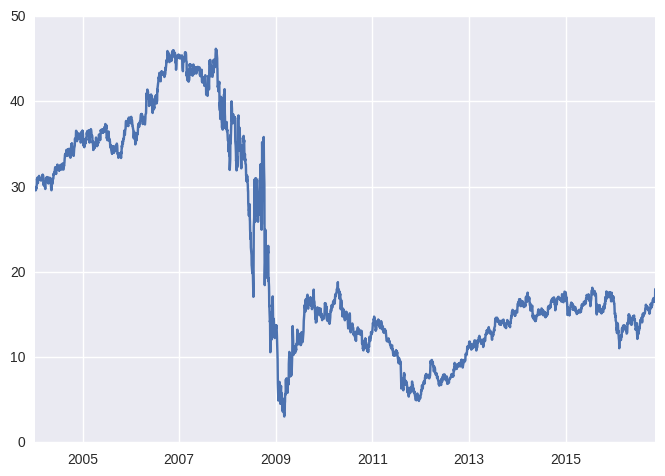

In [39]:
# Plot of entire data
sns.plt.plot(master_stock_data['close'])

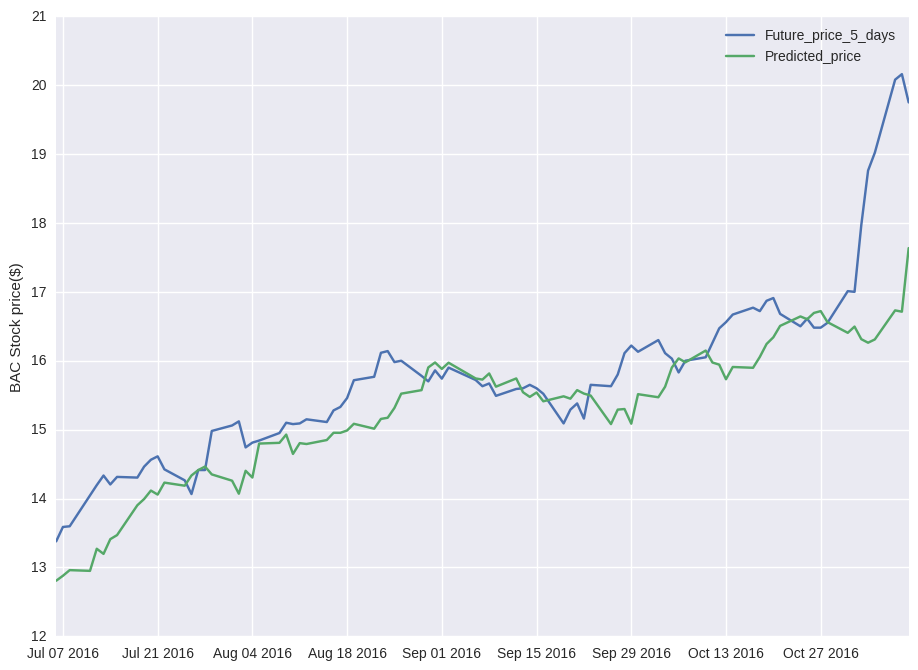

In [40]:
fig, ax = plt.subplots(figsize=(11,8))
ax.plot(prod_data.index, prod_data.future_price, label='Future_price_5_days')
ax.plot(prod_data.index, prod_data.predicted_price, label='Predicted_price')
ax.set_ylabel("BAC Stock price($)")
ax.legend()

In [41]:
feature_importances= pd.DataFrame(zip(prod_X.columns.tolist(),mult_linreg1.coef_), columns=["Features","Coefficient"])

In [42]:
feature_importances.sort_values("Coefficient",inplace=True, ascending=False)

In [43]:
feature_importances

,Features,Coefficient
0,scaled_close,7.453255
10,scaled_lower_bollinger_band,1.600006
7,scaled_rolling_mean,1.589003
9,scaled_upper_bollinger_band,1.571377
6,scaled_daily_return,0.079982
1,scaled_vol,0.026802
5,scaled_put_call_ratio,0.022591
3,scaled_vol_SPY,0.002388
8,scaled_rolling_sd,-0.003393
2,scaled_close_SPY,-0.102142
